<a href="https://colab.research.google.com/github/Svhugani/CryptoAnalysis/blob/main/BITCOIN_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Bit coin analysis**

In [1]:
import math
import numpy as np
import pandas as pd
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Flatten, Dropout, GlobalMaxPooling1D, MaxPool1D, BatchNormalization
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import norm
from scipy.stats import t as tstudent
from scipy.stats import probplot
from scipy.sparse import coo_matrix
from sklearn.utils import shuffle

plt.style.use('dark_background')

In [2]:
START_DATE = '2010-01-01'
END_DATE = '2021-02-10'
ASSET = 'BTC-USD'

In [3]:
df = web.DataReader(ASSET, data_source = 'yahoo', start = START_DATE , end = END_DATE)

In [4]:
df.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800.0,457.334015
2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200.0,424.440002
2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700.0,394.795990
2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600.0,408.903992
2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100.0,398.821014
2014-09-21,406.915985,397.130005,399.100006,402.152008,24127600.0,402.152008
2014-09-22,441.557007,396.196991,402.092010,435.790985,45099500.0,435.790985
2014-09-23,436.112000,421.131989,435.751007,423.204987,30627700.0,423.204987
2014-09-24,423.519989,409.467987,423.156006,411.574005,26814400.0,411.574005


In [5]:
# Add % change and log-% change
df['prev_Close'] = df['Close'].shift(1)
df['return'] = (df['Close'] - df['prev_Close']) / df['Close']
df['log_return'] = np.log(df['return'] + 1)
df.head(5)

,High,Low,Open,Close,Volume,Adj Close,prev_Close,return,log_return
Date,,,,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800.0,457.334015,NaN,NaN,NaN
2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200.0,424.440002,457.334015,-0.077500,-0.080668
2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700.0,394.795990,424.440002,-0.075087,-0.078056
2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600.0,408.903992,394.795990,0.034502,0.033920
2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100.0,398.821014,408.903992,-0.025282,-0.025607


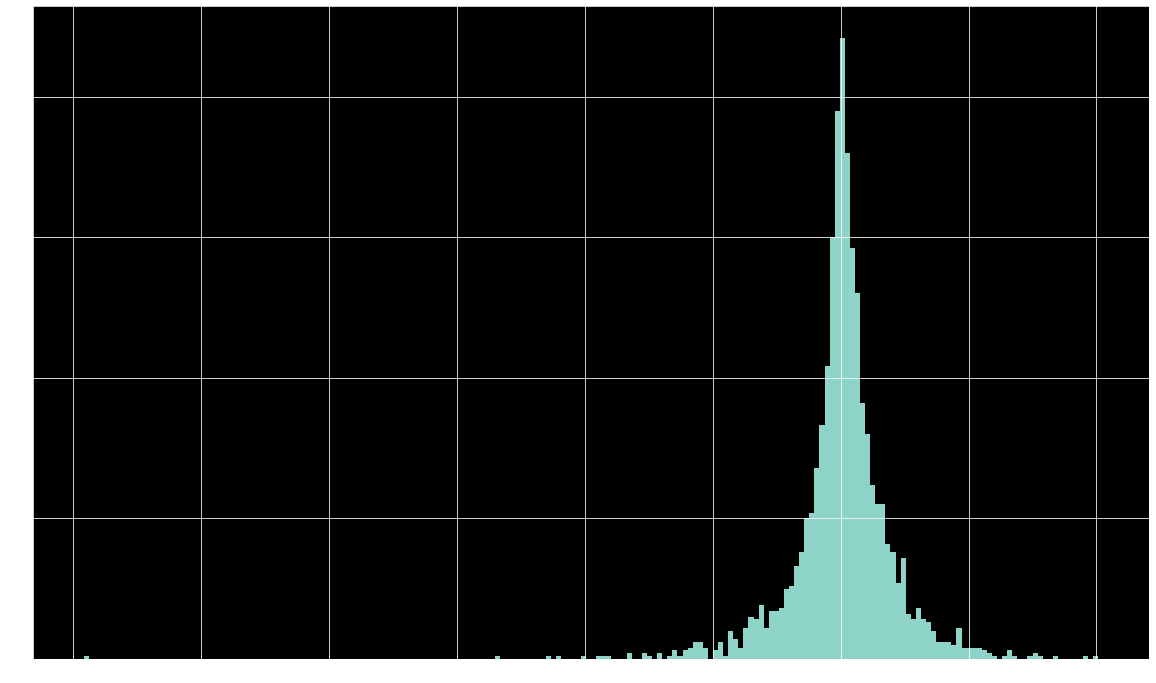

In [6]:
# plot histogram for log returns
plt.subplots(figsize = (20,12))
df['return'].dropna().hist(bins=200)

In [7]:
print("RETURN-MEAN: ", df['return'].mean())
print("RETURN-STDEV: ", df['return'].std())

RETURN-MEAN:  0.001207235856619096
RETURN-STDEV:  0.04024249090077105


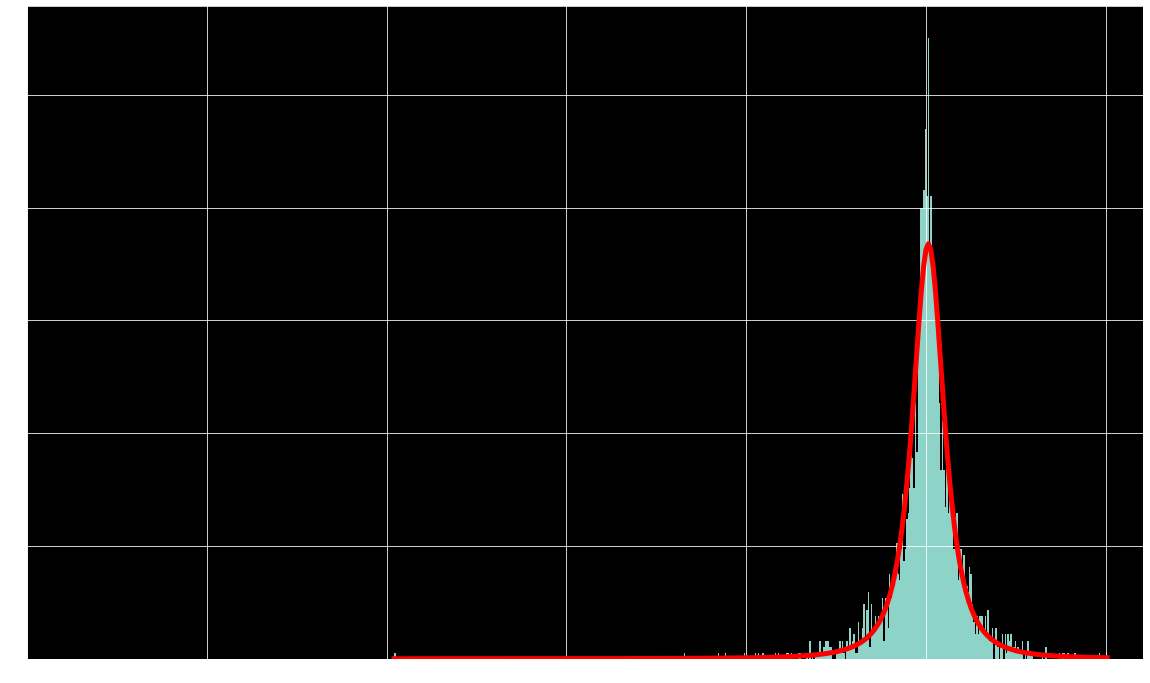

In [8]:
x_sample = np.linspace(df['return'].min(), df['return'].max(), 300)
t_params = tstudent.fit(df['return'].dropna())
t_df, t_loc, t_scale = t_params
y_distr = tstudent.pdf(x_sample, t_df, t_loc, t_scale)
plt.subplots(figsize = (20,12))
plt.plot(x_sample, y_distr, color='red', linewidth=5)
plt.xlim(left=-1)
df['return'].hist(bins=500, density=True)


In [9]:
# my qq-plot function and cut edge data points function 

def my_qq(my_return, n_points):
  dist_t_params = tstudent.fit(my_return.dropna())
  sample = np.linspace(my_return.min(), my_return.max(), len(my_return.dropna()))
  t_pdf = tstudent.pdf(sample, dist_t_params[0], dist_t_params[1], dist_t_params[2])

  x = []
  y = []
  simulation = []

  for _ in range(len(my_return.dropna())):
    simulation.append(tstudent.rvs(dist_t_params[0], dist_t_params[1], dist_t_params[2]))

  p_list = np.linspace(0, 1, n_points)
  df = pd.DataFrame({'data': my_return.dropna().copy(), 'simulation' : simulation })

  for p in p_list:
    y.append(df['data'].quantile(p))
    x.append(df['simulation'].quantile(p))

  return x,y

def my_qq_plot(my_data, frac_list, n_points):
  n = len(frac_list)
  plt.subplots(figsize=(40,6))
  for i in range(n):
    plt.subplot(1, n, i+1)
    data_ = cut_edge_data(my_data, frac_list[i])
    x,y = my_qq(data_['return'], n_points)
    plt.plot(x,y, 'o',label = f"data cut by  {2 * frac_list[i] * 100} %")
    plt.plot(x,x)
    plt.legend()
    plt.grid()
    

def cut_edge_data(my_data, frac):
    if 'return' in my_data.columns:
      my_data_cut = pd.DataFrame(my_data['return'].dropna().copy())
      my_data_cut = my_data_cut[my_data_cut['return']>my_data_cut['return'].quantile(frac)]
      my_data_cut = my_data_cut[my_data_cut['return']<my_data_cut['return'].quantile(1-frac)]
      return my_data_cut
    else:
      raise ValueError('No "return" in columns.')


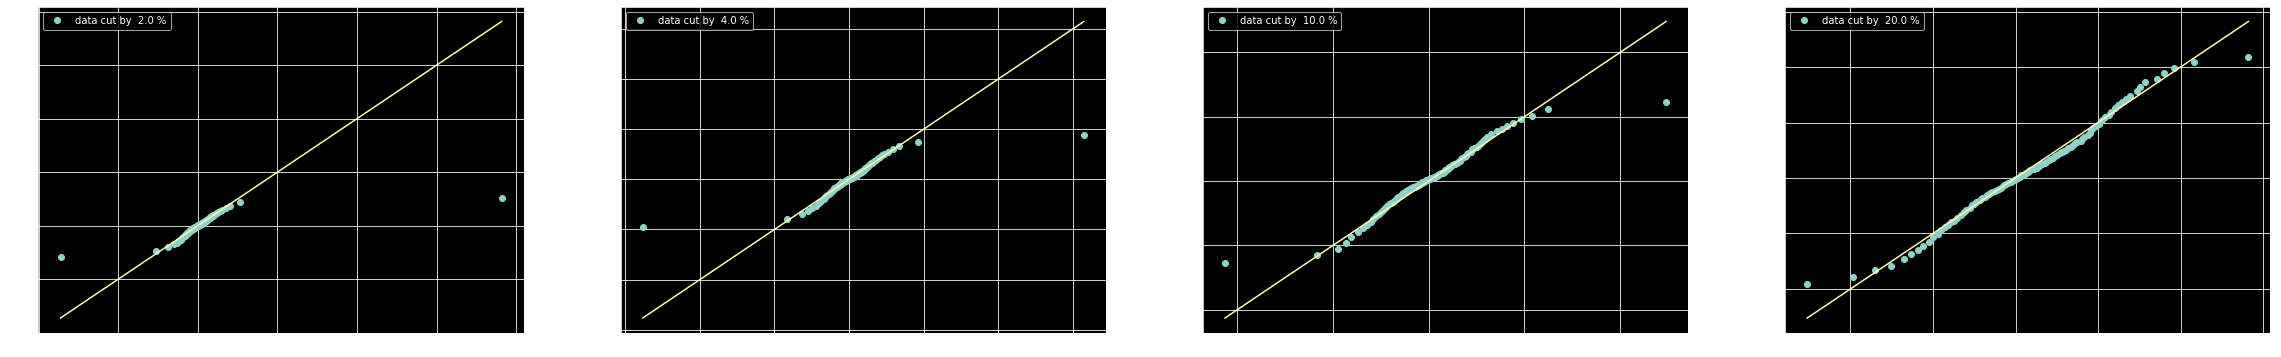

In [10]:
my_qq_plot(df, [0.01, 0.02, 0.05, 0.1], 100)

In [11]:
close_prices = df['Close'].copy()

In [12]:
def plot_stats(my_data, last_steps):
  plot_data = pd.DataFrame(my_data['return'][-last_steps:].copy())
  plot_data['slow_sma'] = plot_data['return'].rolling(10).mean()
  plot_data['mid_sma'] = plot_data['return'].rolling(30).mean()
  plot_data['fast_sma'] = plot_data['return'].rolling(7).mean()
  plot_data[['return', 'slow_sma', 'mid_sma', 'fast_sma']].plot(figsize=(40,10))
  plt.legend()
  plt.grid()



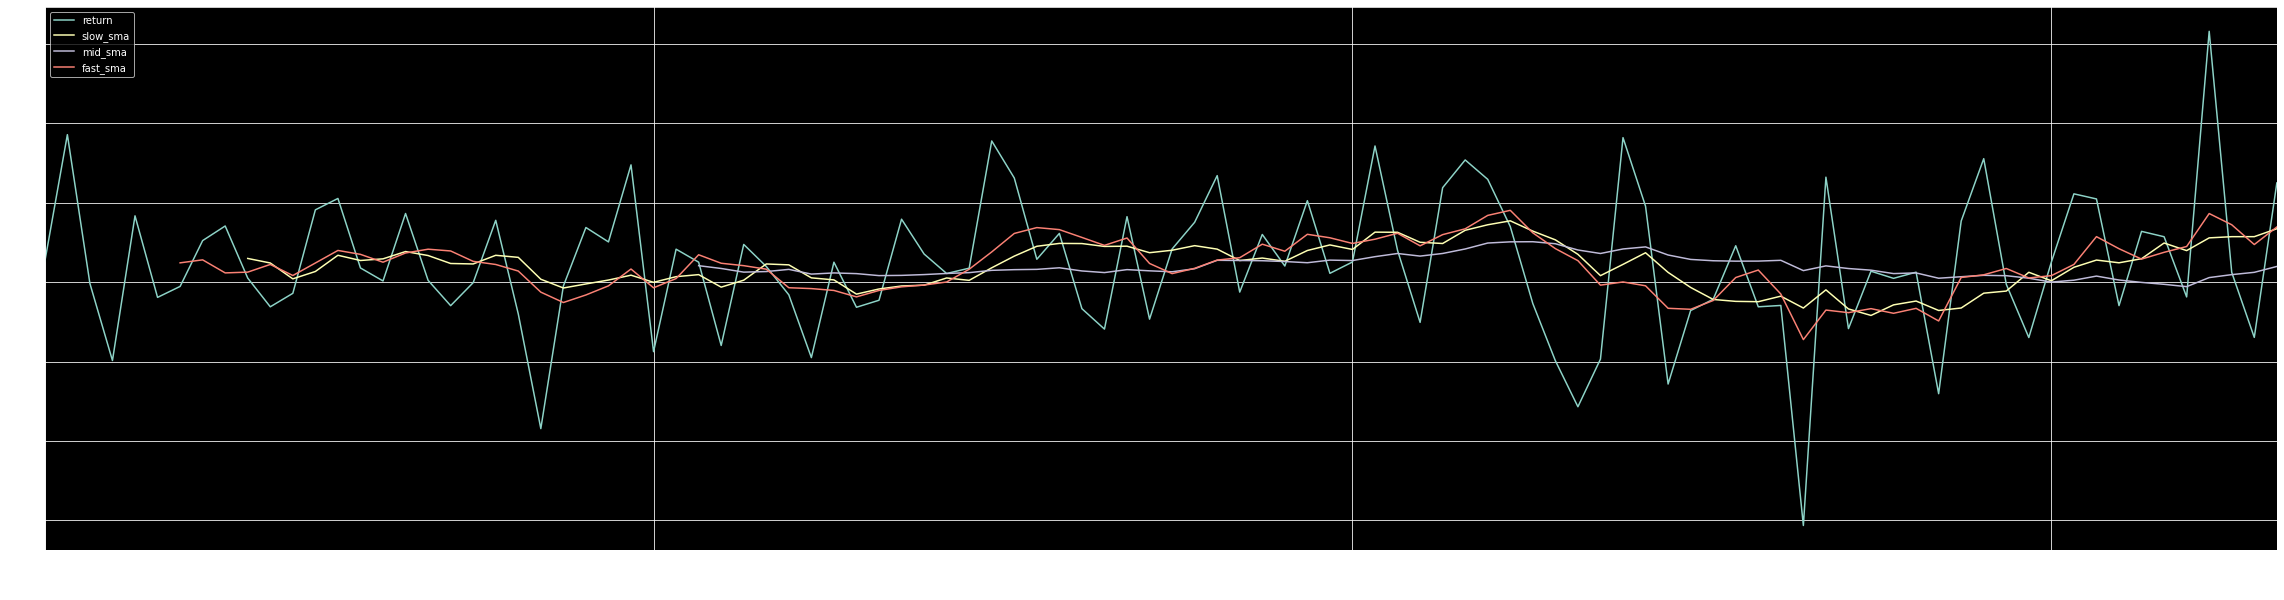

In [13]:
plot_stats(df,100)

# **2. Machine learning part**

work in progres....

**2.1 Predict 1 day ahead with 1D CNN**

2.1.1 Based on return prices only

In [15]:
def generate_sequence_data(raw_r, window_size, dist_params):
  '''
    Generate additional data for price simulation according to t-distribution/or other
  '''
  r = np.random.choice(raw_r)
  generated_window = []
  for i in range(0, window_size + 1):
    generated_window.append(r * (1 + tstudent.rvs(dist_params[0], dist_params[1], dist_params[2])))
  return np.array(generated_window)


In [30]:
def generate_test_train_sets(df_, window_size, train_test_split=.8 , dist_params=t_params, preprocess=False):
  '''
    In order to predict 1 future return ( up or down) generate widow_size sequences labelled with 1 for up prive movement
    and 0 for down price movement at first data point after the sequence with defined window. Then to balance data if necessary
    generate more data according to the fitted t-student distribution
  '''
  raw_returns = df_['return'].dropna().values

  if preprocess:
    scaler = StandardScaler()
    raw_returns = scaler.fit(raw_returns)

  N = len(raw_returns)
  X = []
  Y = []
  i = 0

  while (i + window_size < N):
    x_window = raw_returns[i : i + window_size]
    X.append(x_window)
    if raw_returns[i + window_size] > 0:
      Y.append(1)
    else:
      Y.append(0)
    i += 1

  X = np.array(X)
  Y = np.array(Y)
  ind = int(N * train_test_split)
  x_train, x_test = X[:ind], X[ind:]
  y_train, y_test = Y[:ind], Y[ind:]

  positive_trends = 0
  negative_trends = 0
  for el in y_train:
    if el == 1:
      positive_trends += 1
    else:
      negative_trends += 1
  balance = 100 * (float)(positive_trends) / (positive_trends + negative_trends)
  
  if abs(balance - 50) > 1:
    print(f"The the data is umbalanced. There is {positive_trends} +trends and {negative_trends} -trends. Generating new data... \n")
    
    data_points_to_fill = abs(positive_trends - negative_trends)
    if positive_trends - negative_trends > 0:
      desired_trend = 0
    else: 
      desired_trend = 1
    while data_points_to_fill > 0:
      generated = generate_sequence_data(raw_returns, window_size, dist_params)
      last_point = (1 if generated[-1] > 0 else 0)
      if last_point == desired_trend:
        x_train = np.append(x_train, generated[:-1].reshape(1,-1), axis=0)
        y_train = np.append(y_train, last_point)
        data_points_to_fill -= 1
        if desired_trend == 1:
          positive_trends += 1
        else:
          negative_trends += 1
    print(f"Now the data is balanced. There is {positive_trends} +trends and {negative_trends} -trends. Continue... \n")
  

  x_train, y_train = shuffle(x_train, y_train)

  return x_train, x_test, y_train, y_test

In [50]:
'''
  Generate train/test sets with window size (40)
'''
x_train, x_test, y_train, y_test = generate_test_train_sets(df, 20)

The the data is umbalanced. There is 1028 +trends and 840 -trends. Generating new data... 

Now the data is balanced. There is 1028 +trends and 1028 -trends. Continue... 



In [51]:
def my_conv1D_model(input_shape, is_batch_normalize=True):
  '''
    Machine learning model build from tensorflow API.
    It's mainly convolutional nn model witch optional batch-normalization layers followedn by dense nn and dropout layers.
  '''
  i = Input(shape = input_shape)
  x = Conv1D(32, 3, activation = 'relu')(i)
  if is_batch_normalize:
    x = BatchNormalization()(x)
  x = Conv1D(32, 3, activation = 'relu')(x)
  x = MaxPool1D(pool_size = 2)(x)
  x = Conv1D(64, 3, activation = 'relu')(x)
  if is_batch_normalize:
    x = BatchNormalization()(x)
  x = Conv1D(64, 3, activation = 'relu')(x)
  x = MaxPool1D(pool_size = 2)(x)
  x = Flatten()(x)
  x = Dense(64, activation = 'relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(2, activation = 'softmax')(x)
  model =  Model(i, x)
  return model


In [52]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
btc_model = my_conv1D_model(x_train[0].shape, is_batch_normalize=False)
btc_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
r = btc_model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 20)

Epoch 1/20
65/65 [==============================] - 1s 9ms/step - loss: 0.6934 - accuracy: 0.4654 - val_loss: 0.6940 - val_accuracy: 0.4497
Epoch 2/20
65/65 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.4959 - val_loss: 0.6926 - val_accuracy: 0.5369
Epoch 3/20
65/65 [==============================] - 0s 6ms/step - loss: 0.6785 - accuracy: 0.5752 - val_loss: 0.6870 - val_accuracy: 0.5570
Epoch 4/20
65/65 [==============================] - 0s 6ms/step - loss: 0.6740 - accuracy: 0.5520 - val_loss: 0.6868 - val_accuracy: 0.5638
Epoch 5/20
65/65 [==============================] - 0s 6ms/step - loss: 0.6465 - accuracy: 0.5797 - val_loss: 0.6871 - val_accuracy: 0.5503
Epoch 6/20
65/65 [==============================] - 0s 6ms/step - loss: 0.6553 - accuracy: 0.5744 - val_loss: 0.6936 - val_accuracy: 0.5548
Epoch 7/20
65/65 [==============================] - 0s 6ms/step - loss: 0.6420 - accuracy: 0.5911 - val_loss: 0.6895 - val_accuracy: 0.5459
Epoch 8/20
65/65 [==

Text(0.5, 1.0, 'Loss-epoch and Accuracy-epoch evolutions')

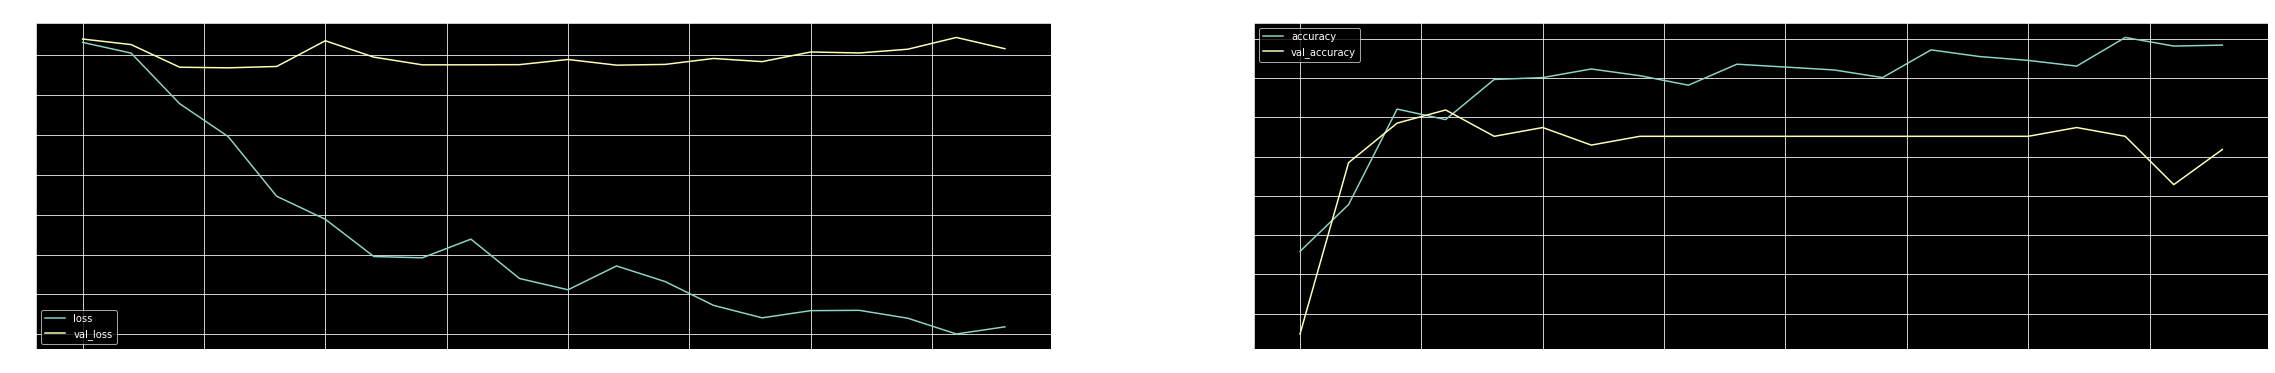

In [53]:
plt.subplots(figsize=(40,6))
plt.subplot(1,2,1)
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.grid()
plt.title("Loss-epoch and Accuracy-epoch evolutions")